In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
    .config("spark.driver.memory", "16g")\
    .getOrCreate()

spark

your 131072x1 screen size is bogus. expect trouble


23/05/24 16:14:12 WARN Utils: Your hostname, HOMELAB resolves to a loopback address: 127.0.1.1; using 192.168.75.74 instead (on interface eth0)
23/05/24 16:14:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/24 16:14:14 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
import pyspark.sql.types as T
import matplotlib

from cycler import cycler
from pyspark.sql.functions import col, lit

from common import *

plt.rc('axes', labelsize=15, titlesize=15) 
plt.rc('xtick', labelsize=14)
plt.rc('ytick', labelsize=14)
plt.rc('legend', fontsize=15)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [3]:
PREFIX = "main/tpcc"
IGNORE_CACHE = False

index_df = from_cache_or_compute(
    f'{PREFIX}/index.parquet',
    lambda: get_index(spark, PREFIX)\
        .withColumn("sample", col("sample").cast(T.IntegerType()))\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

index_df

,prefix,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
0,file:/home/ctring/data/detock/main/tpcc/janus-...,1.0.1082,janus.conf,30,0,1250,0,10,tpcc,0,45:43:4:4:4,1,2,-1
1,file:/home/ctring/data/detock/main/tpcc/calvin...,1.0.1061,calvin_paxos.conf,30,0,1000,0,10,tpcc,0,45:43:4:4:4,1,2,-1
2,file:/home/ctring/data/detock/main/tpcc/janus-...,1.0.1082,janus.conf,30,0,1000,0,10,tpcc,0,45:43:4:4:4,1,2,-1
3,file:/home/ctring/data/detock/main/tpcc/janus-...,1.0.1082,janus.conf,30,0,1750,0,10,tpcc,0,45:43:4:4:4,1,2,-1
4,file:/home/ctring/data/detock/main/tpcc/janus-...,1.0.1082,janus.conf,30,0,1500,0,10,tpcc,0,45:43:4:4:4,1,2,-1
5,file:/home/ctring/data/detock/main/tpcc/janus-...,1.0.1082,janus.conf,30,0,2250,0,10,tpcc,0,45:43:4:4:4,1,2,-1
6,file:/home/ctring/data/detock/main/tpcc/janus-...,1.0.1082,janus.conf,30,0,2000,0,10,tpcc,0,45:43:4:4:4,1,2,-1
7,file:/home/ctring/data/detock/main/tpcc/baseli...,1.0.1075,baseline.conf,30,0,125,0,10,tpcc,0,45:43:4:4:4,1,2,-1
8,file:/home/ctring/data/detock/main/tpcc/baseli...,1.0.1075,baseline.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1
9,file:/home/ctring/data/detock/main/tpcc/baseli...,1.0.1075,baseline.conf,30,0,175,0,10,tpcc,0,45:43:4:4:4,1,2,-1


# Throughput

In [4]:
IGNORE_CACHE = False

def compute_throughput(prefix):
    res = throughput(
        spark,
        prefix,
        start_offset_sec=5,
        duration_sec=20,
    ).first().throughput
    print(prefix, res)
    return res


def compute_all_throughputs(index_df):
    # Extract all prefixes in the index
    throughput_df = index_df.loc[:, ["prefix"]]
    # Compute the throughput of each prefix
    throughput_df["throughput"] = throughput_df.apply(lambda r : compute_throughput(r["prefix"]), axis=1)
    # Associate metadata from the index to the throughputs
    return throughput_df.merge(index_df, on="prefix")


throughput_df = from_cache_or_compute(
    f'{PREFIX}/throughput.parquet',
    lambda: compute_all_throughputs(index_df),
    ignore_cache=IGNORE_CACHE,
)

throughput_df

,prefix,throughput,version,config_name,duration,txns,clients,rate,sample,wl:name,wl:sh_only,wl:mix,wl:mh_zipf,wl:homes,wl:sp_partition
index,,,,,,,,,,,,,,,
0,file:/home/ctring/data/detock/main/tpcc/janus-...,37581.345700,1.0.1082,janus.conf,30,0,1250,0,10,tpcc,0,45:43:4:4:4,1,2,-1
1,file:/home/ctring/data/detock/main/tpcc/calvin...,33545.172332,1.0.1061,calvin_paxos.conf,30,0,1000,0,10,tpcc,0,45:43:4:4:4,1,2,-1
2,file:/home/ctring/data/detock/main/tpcc/janus-...,32982.592973,1.0.1082,janus.conf,30,0,1000,0,10,tpcc,0,45:43:4:4:4,1,2,-1
3,file:/home/ctring/data/detock/main/tpcc/janus-...,39205.901413,1.0.1082,janus.conf,30,0,1750,0,10,tpcc,0,45:43:4:4:4,1,2,-1
4,file:/home/ctring/data/detock/main/tpcc/janus-...,39687.190016,1.0.1082,janus.conf,30,0,1500,0,10,tpcc,0,45:43:4:4:4,1,2,-1
5,file:/home/ctring/data/detock/main/tpcc/janus-...,40567.744114,1.0.1082,janus.conf,30,0,2250,0,10,tpcc,0,45:43:4:4:4,1,2,-1
6,file:/home/ctring/data/detock/main/tpcc/janus-...,40299.725590,1.0.1082,janus.conf,30,0,2000,0,10,tpcc,0,45:43:4:4:4,1,2,-1
7,file:/home/ctring/data/detock/main/tpcc/baseli...,42855.860978,1.0.1075,baseline.conf,30,0,125,0,10,tpcc,0,45:43:4:4:4,1,2,-1
8,file:/home/ctring/data/detock/main/tpcc/baseli...,39700.402886,1.0.1075,baseline.conf,30,0,100,0,10,tpcc,0,45:43:4:4:4,1,2,-1


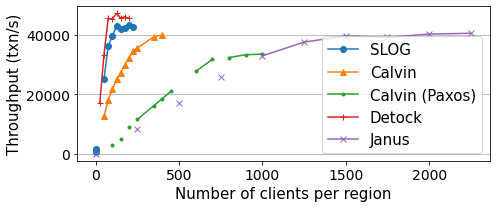

In [5]:
pivot_values = "throughput"
pivot_columns = "config_name"
pivot_index = "clients"
pivoted = throughput_df.pivot(index=pivot_index, columns=pivot_columns, values=pivot_values).sort_index()
pivoted["clients"] = pivoted.index
pivoted.rename(columns={
    "baseline.conf": "SLOG",
    "ddr_ts.conf": "Detock",
    "calvin.conf": "Calvin",
    "calvin_paxos.conf": "Calvin (Paxos)",
    "janus.conf": "Janus",
}, inplace=True)
pivoted.columns.name = ''

ax = pivoted.plot(x="clients", xlabel="Number of clients per region", ylabel='Throughput (txn/s)', rot=0, legend=False, figsize=(7,3))

markers = ["o", "^", ".", "+", "x"]
for i, line in enumerate(ax.get_lines()):
    line.set_marker(markers[i])

ax.legend(ax.get_lines(), pivoted.columns)

plt.grid(axis='y')
plt.tight_layout()
plt.savefig('output/tpcc-throughput.pdf')

# Latency

# By regions

In [6]:
index_sdf = get_index(spark, PREFIX)

latency_sdf = latency(spark, map(
        lambda r : r.prefix,
        index_sdf.select("prefix").collect(),
    ))\
    .join(index_sdf, on="prefix")\
    .withColumn(
        "coordinator_region",
        F.when(F.col("config_name") == "calvin.conf", F.shiftright(col("coordinator"), 16))\
            .when(F.col("config_name") == "calvin_paxos.conf", F.shiftright(col("coordinator"), 16))\
            .when(F.col("config_name") == "janus.conf", F.shiftright(col("coordinator"), 24))\
            .when(F.col("config_name") == "baseline.conf", F.shiftright(col("coordinator"), 24))\
            .otherwise(F.col("coordinator") / 4)\
        .cast(T.IntegerType())
    )\
    .orderBy("clients")\
    .cache()

In [7]:
def plot_latency_per_region(sdf_dict, order, cycle):
    rows = 2
    cols = 4
    fig, ax = plt.subplots(rows, cols, figsize=(14, 6), sharex=True, sharey=True)
    regions = [
        "us-east-2",
        "us-east-1",
        "eu-west-1",
        "eu-west-2",
        "ap-northeast-1",
        "ap-northeast-2",
        "ap-southeast-1",
        "ap-southeast-2"
    ]
    for i in range(8):
        r, c = i // cols, i % cols
        ax[r, c].set_prop_cycle(cycle)
        for label in order:
            sdf = sdf_dict[label]
            plot_cdf(
                collect_col(sdf.where(col("coordinator_region") == i), "latency"),
                ax=ax[r, c],
                label=label if i == 0 else '_nolegend_',
                linewidth=2,
            )

        ax[r, c].set_title(f"{regions[i]}")
        if r == rows - 1:
            ax[r, c].set_xlabel("latency (ms)")
        # set vertical grid for ax
        ax[r, c].grid(axis='x')

    return fig, ax


23/05/24 16:14:56 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients25/client/3/transactions.csv
23/05/24 16:14:56 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients25/client/6/transactions.csv
23/05/24 16:14:56 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file:

23/05/24 16:15:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients75/client/3/transactions.csv
23/05/24 16:15:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients75/client/2/transactions.csv
23/05/24 16:15:01 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file:

23/05/24 16:15:03 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients125/client/3/transactions.csv
23/05/24 16:15:03 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients125/client/4/transactions.csv
23/05/24 16:15:03 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV fil

23/05/24 16:15:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients200/client/6/transactions.csv
23/05/24 16:15:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients200/client/5/transactions.csv
23/05/24 16:15:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV fil

23/05/24 16:15:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients200/client/4/transactions.csv
23/05/24 16:15:06 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients50/client/2/transactions.csv


23/05/24 16:15:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients175/client/3/transactions.csv
23/05/24 16:15:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients175/client/4/transactions.csv
23/05/24 16:15:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV fil

23/05/24 16:15:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients150/client/3/transactions.csv
23/05/24 16:15:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients150/client/2/transactions.csv
23/05/24 16:15:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV fil

23/05/24 16:15:07 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients150/client/1/transactions.csv


23/05/24 16:15:11 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients100/client/3/transactions.csv
23/05/24 16:15:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients100/client/4/transactions.csv
23/05/24 16:15:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV fil

23/05/24 16:15:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients100/client/6/transactions.csv
23/05/24 16:15:12 WARN CSVHeaderChecker: CSV header does not conform to the schema.
 Header: txn_id, coordinator, replicas, partitions, sent_at, received_at
 Schema: txn_id, coordinator, regions, partitions, sent_at, received_at
Expected: regions but found: replicas
CSV file: file:///home/ctring/data/detock/main/tpcc/ddr_ts-clients100/client/0/transactions.csv
23/05/24 16:15:12 WARN DAGScheduler: Broadcasting large task binary with size 1270.2 KiB


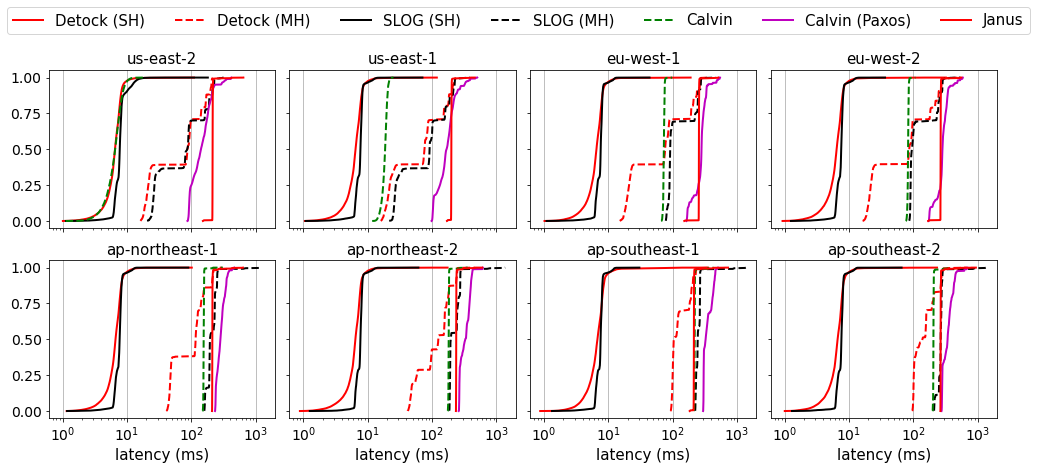

In [8]:
baseline_sdf = latency_sdf.where((col("config_name") == "baseline.conf") & (col("clients") == 2)).cache()
ddr_ts_sdf = latency_sdf.where((col("config_name") == "ddr_ts.conf") & (col("clients") == 25)).cache()
calvin_sdf = latency_sdf.where((col("config_name") == "calvin.conf") & (col("clients") == 50)).cache()
calvin_paxos_sdf = latency_sdf.where((col("config_name") == "calvin_paxos.conf") & (col("clients") == 100)).cache()
janus_sdf = latency_sdf.where((col("config_name") == "janus.conf") & (col("clients") == 250)).cache()

MH_FILTER = F.size("regions") > 1
SH_FILTER = F.size("regions") == 1

fig, _ = plot_latency_per_region({
        "Detock (SH)": ddr_ts_sdf.where(SH_FILTER),
        "Detock (MH)": ddr_ts_sdf.where(MH_FILTER),
        "SLOG (SH)": baseline_sdf.where(SH_FILTER),
        "SLOG (MH)": baseline_sdf.where(MH_FILTER),
        "Calvin": calvin_sdf,
        "Calvin (Paxos)": calvin_paxos_sdf,
        "Janus": janus_sdf,
    },
    [
        "Detock (SH)",
        "Detock (MH)",
        "SLOG (SH)",
        "SLOG (MH)",
        "Calvin",
        "Calvin (Paxos)",
        "Janus"
    ],
    # cycler(alpha=[0.5, 0.5, 0.5, 1, 1]) + cycler(color='gkkrr') + cycler(linestyle=['-', '--', '-', '--', '-']),
    cycler(color='rrkkgm') + cycler(linestyle=['--', '-', '--', '-', '--', '-']),
)

fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', ncol=7)
fig.tight_layout()
fig.savefig('output/tpcc-cdf.pdf', bbox_inches='tight')

# Throughput & Latency

In [9]:
IGNORE_CACHE = False

percentile_cols = [
    F.percentile_approx("latency", 0.5).alias("percentile_50"),
    F.percentile_approx("latency", 0.90).alias("percentile_90"),
    F.percentile_approx("latency", 0.95).alias("percentile_95"),
    F.percentile_approx("latency", 0.99).alias("percentile_99"),
]

baseline_pct = from_cache_or_compute(
    f'{PREFIX}/baseline_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "baseline.conf"))\
        .groupBy("clients")\
        .agg(*percentile_cols)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

ddr_ts_pct = from_cache_or_compute(
    f'{PREFIX}/ddr_ts_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "ddr_ts.conf"))\
        .groupBy("clients")\
        .agg(*percentile_cols)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

calvin_pct = from_cache_or_compute(
    f'{PREFIX}/calvin_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "calvin.conf"))\
        .groupBy("clients")\
        .agg(*percentile_cols)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

janus_pct = from_cache_or_compute(
    f'{PREFIX}/janus_latency_pct.parquet',
    lambda: latency_sdf.where((col("config_name") == "janus.conf"))\
        .groupBy("clients")\
        .agg(*percentile_cols)\
        .toPandas(),
    ignore_cache=IGNORE_CACHE,
)

latency_pct_df = pd.concat([
    baseline_pct.assign(config_name="baseline.conf"),
    ddr_ts_pct.assign(config_name="ddr_ts.conf"),
    calvin_pct.assign(config_name="calvin.conf"),
    janus_pct.assign(config_name="janus.conf"),
])

throughput_latency_df = throughput_df[["config_name", "clients", "throughput"]].merge(
    latency_pct_df,
    on=["config_name", "clients"]
).sort_values("clients")
throughput_latency_df.sort_values(["config_name", "throughput"])

,config_name,clients,throughput,percentile_50,percentile_90,percentile_95,percentile_99
37,baseline.conf,1,496.620898,7.427328,8.369664,26.319616,257.234176
36,baseline.conf,2,1028.820076,7.689984,9.070592,22.602752,250.141952
39,baseline.conf,3,1537.511952,7.716096,10.196224,22.396416,249.357056
29,baseline.conf,50,25099.990042,6.966272,17.789696,41.999872,260.749056
30,baseline.conf,75,36210.112027,7.234816,20.607488,47.080192,261.156608
7,baseline.conf,100,39700.402886,7.860736,26.405120,79.245568,269.027840
9,baseline.conf,150,41851.058963,8.990976,47.223040,146.501888,353.417984
8,baseline.conf,175,42463.393414,9.645056,72.685568,180.486656,557.408512
12,baseline.conf,225,42624.451220,10.836992,99.159552,227.786240,803.076352
6,baseline.conf,125,42855.860978,8.567040,31.359488,105.534720,279.988480


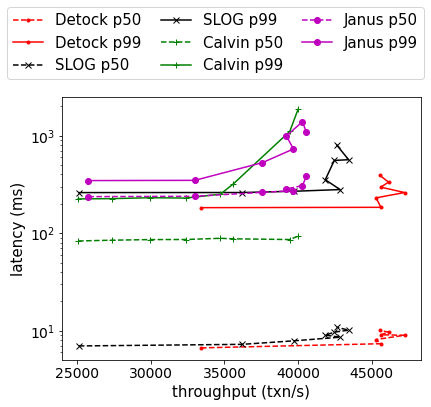

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5))
config_names = ["ddr_ts.conf", "baseline.conf", "calvin.conf", "janus.conf"]
config_to_label = {
    'baseline.conf': 'SLOG',
    'ddr_only.conf': 'Detock (without Opportunistic Ordering)',
    'ddr_ts.conf': 'Detock',
    'calvin.conf': 'Calvin',
    'janus.conf': 'Janus',
}

ax.set_prop_cycle((cycler(marker=['.', 'x', '+', 'o']) + cycler(color='rkgm')) * cycler(linestyle=['--', '-']))

for config in config_names:
    label = config_to_label[config]
    mask = throughput_latency_df.config_name == config
    if config == "calvin.conf":
        mask &= throughput_latency_df.clients > 100
    elif config == "janus.conf":
        mask &= throughput_latency_df.clients > 500
    else:
        mask &= throughput_latency_df.clients > 25
    throughput_latency_df[mask].plot(x="throughput", y="percentile_50", label=f"{label} p50", ax=ax, legend=False)
    throughput_latency_df[mask].plot(x="throughput", y="percentile_99", label=f"{label} p99", ax=ax, legend=False)

ax.set_yscale('log')
ax.set_ylabel("latency (ms)")
ax.set_xlabel("throughput (txn/s)")
fig.legend(bbox_to_anchor=(0, 1, 1, 0), loc='lower left', mode='expand', ncol=3)
fig.tight_layout()
fig.savefig('output/tpcc-throughput-latency.pdf', bbox_inches='tight')
fig.savefig('output/tpcc-throughput-latency.jpg', bbox_inches='tight')